<div><img src="blob/structure.jpg" width=400px float="left"/></div>

# SVG to Text with CNN and Transformer

In [1]:
import io
import os
import math
import numpy as np
import random

import matplotlib.pyplot as plt
from IPython.display import clear_output
# from cairosvg import svg2png
from IPython.display import SVG, display
import svgwrite
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
from nltk.translate.bleu_score import corpus_bleu

from sklearn.model_selection import train_test_split

from model import *
import svg_converter as converter

C:\Users\Ганга Сэм\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device.type

'cuda'

### Preprocessing

In [3]:
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

def names_to_file(fn_tok_path, folder_path):
    with open(fn_tok_path, 'w') as f:
        filenames = []

        for root, _, files in os.walk(folder_path):
            for file in files:
                filename, extension = os.path.splitext(file)
                if extension == '.svg':
                    filenames.append(filename)

        for line in filenames:
            filename = line.strip()
            f.write(tokenize(filename) + "\n")

def get_svg_paths(folders):
    svg_paths = []

    for i, folder in enumerate(folders):
        files = [file for file in os.listdir(folder)]

        for file in files:
            svg_name = file[:-4] # del ".svg"
            svg_name = svg_name.strip().split('_')

            if len(svg_name) > 1:
                svg_name = svg_name[1]
            else:
                svg_name = svg_name[0]
                
            svg_name = svg_name.replace('-', ' ')
            svg_name = tokenize(svg_name)
            svg_name = filenames_bpe.process_line(svg_name)

            svg_path = os.path.join(folder, file)

            svg_paths.append([svg_name, svg_path])

    return svg_paths

In [4]:
dataset_path = 'dataset2k'
tokenizer = WordPunctTokenizer()

In [5]:
fn_tok_path = 'dataset2k/filenames_tokenized.txt'
names_to_file(fn_tok_path, dataset_path)
learn_bpe(open(fn_tok_path), open('tmp_bpe_rules.fnt', 'w'),  num_symbols=1000)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1129.62it/s]


In [6]:
filenames_bpe = BPE(open('tmp_bpe_rules.fnt'))

In [7]:
folders = os.listdir(dataset_path)
folders = [os.path.join(dataset_path, foldername)
           for foldername in folders
           if os.path.isdir(os.path.join(dataset_path, foldername))]

print(len(folders))

all_svg_paths = np.array(get_svg_paths(folders))

2000


In [8]:
len(all_svg_paths), all_svg_paths[:5]

(134501,
 array([['1 pa@@ ss@@ wor@@ d', 'dataset2k\\1\\1 password.svg'],
        ['1 p@@ et@@ e', 'dataset2k\\1\\1 pete.svg'],
        ['1 star', 'dataset2k\\1\\1 star.svg'],
        ['a@@ do@@ be in@@ design 1',
         'dataset2k\\1\\adobe indesign 1.svg'],
        ['ba@@ llo@@ on 1', 'dataset2k\\1\\balloon 1.svg']], dtype='<U192'))

In [9]:
train_paths, test_paths = train_test_split(
    all_svg_paths,
    test_size=0.2,
    random_state=42,
)

In [10]:
len(train_paths), len(test_paths), train_paths[0]

(107600,
 26901,
 array(['wal@@ ker or run@@ ner spor@@ tive stick man',
        'dataset2k\\man\\walker or runner sportive stick man.svg'],
       dtype='<U192'))

In [11]:
voc = Vocab.from_lines(all_svg_paths[:,0])
len(voc)

1062

### Train

In [12]:
batch_size = 16
seq_len = 512

c = converter.Converter(seq_len)

train_dataset = SvgDataset(train_paths, seq_len=seq_len, device=device, transforms=True)
test_dataset = SvgDataset(test_paths, seq_len=seq_len, device=device)

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle = True)

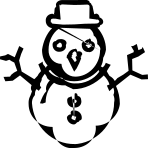

sno@@ w@@ man w@@ int@@ er


In [13]:
for vec, tgt in train_dl:
    show(c, vec[0])
    print(tgt[0])
    break

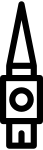

big b@@ en clock


In [14]:
for vec, tgt in test_dl:
    show(c, vec[0])
    print(tgt[0])
    break

In [15]:
model = STTModel(
    vocab_size=1070,
    voc=voc,
    dim=64,
    seq_len=seq_len,
    n_heads=8,
    n_encoder_layers=2,
    n_decoder_layers=3,
    dropout_p=0.1,
).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss().to(device)

In [16]:
step = -1
metrics = {'train_loss': [], 'test_loss': []}
save_path = "checkpoints"

# step, metrics = load_checkpoint(model, opt, save_path, 'epoch', 186_500, device)
step

-1

Epoch: 24, step: 166600, loss: 1.4507920742034912, test_loss: 1.1147583723068237


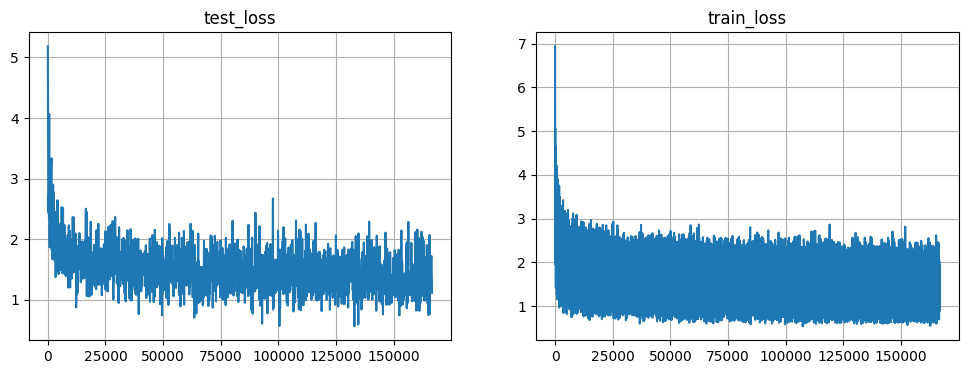

KeyboardInterrupt: 

In [17]:
train(model,
      opt,
      loss_fn,
      train_dl=train_dl,
      test_dl=test_dl,
      device=device,
      metrics=metrics,
      save_path=save_path,
      step=step,
      converter=c,
      epochs=128,
     )

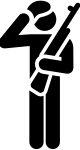

target: soldier
result: criminal with a knife


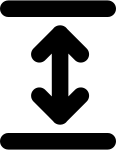

target: arrow fit height
result: heart shaped shield


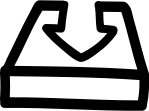

target: download hand drawn interface symbol of a tray with a descending arrow on it
result: barbecue music and multimedia


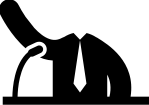

target: man talking on business presentation behind a podium with a mic
result: black flag


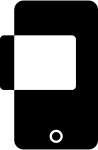

target: chat smartphone
result: lamp


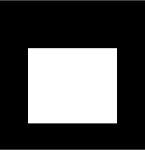

target: medicine bottle
result: down arrow in a circle


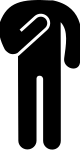

target: man swearing
result: arrow pointing to right


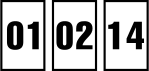

target: calendar with three rotatory areas on february 1 of 2014
result: phone with a call small symbol on screen


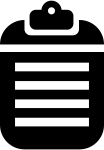

target: clipboard with textdocument
result: arrow pointing to the left


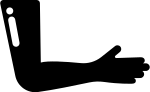

target: human arm
result: man with sunglasses


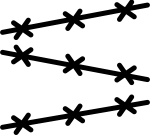

target: barbed wire security
result: american football player running with the ball


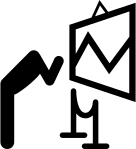

target: museum visit museum show exhibit
result: sad face with eyes and straight mouth line


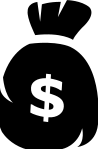

target: dollar sign bag
result: heart shaped diamond ring


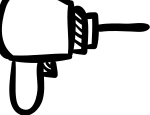

target: drill hand drawn contruction tool
result: santa claus standing with a cane in one hand and a


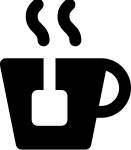

target: tea cup coffee cup
result: arrow pointing to the left


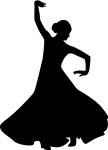

target: flamenco female dancer silhouette with raised right arm
result: sunglasses


In [21]:
sample(c, model, test_dl, device=device, p_value=0.1)